# Sequence Detector

## Necessary modules

In [8]:
# Import Modules
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
import sys
import tarfile
import seaborn
import random
from tensorflow.examples.tutorials.mnist import input_data
from IPython.display import display, Image
from scipy import ndimage
from scipy.io import loadmat
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matlotlib backend as plotting inline in IPython
%matplotlib inline

## Generic functions

### Data Preprocessing Functions

In [9]:
last_percent_reported = None
num_classes = 10

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 1% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  downloaded = False
  if force or not os.path.exists(FOLDER + filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(URL + filename, FOLDER + filename, reporthook=download_progress_hook)
    downloaded = True
    print('\nDownload Complete!')
  if downloaded:
    statinfo = os.stat(filename)
  else:
    statinfo = os.stat(FOLDER + filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

def maybe_extract(filename, force=False):
  """Extract a file (tar). If force=True, override the current files and folders"""
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall()
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders

### Eval Functions

In [10]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == labels)
          / predictions.shape[0])

def pred_acc(predictions, labels):
  return (100.0 * np.sum(predictions == labels)
          / predictions.shape[0])

def check_predictions(original, labels, predictions):
  print('Accuracy: %.1f%%' % pred_acc(predictions, labels))
  for i, sample in enumerate(original):
    sample = sample.reshape(sample.shape[0], sample.shape[1],).astype(np.float32)
    plt.imshow(sample)
    plt.show()
    print('Label %s - Prediction %s' % (int(labels[i]), int(predictions[i])))
    if (i == 10):
      break

## 2. STEP TWO: SINGLE DIGIT SVHN DATA

### Downloading data or [load data from pickle file](#Load-data)

In [5]:
URL = 'http://ufldl.stanford.edu/housenumbers/'
FOLDER = '../data/SVHN_data/'
TRAIN_FILENAME= 'train_32x32.mat'
TEST_FILENAME = 'test_32x32.mat'
EXTRA_FILENAME = 'extra_32x32.mat'

train_filename = maybe_download(TRAIN_FILENAME, 182040794)
test_filename = maybe_download(TEST_FILENAME, 64275384)
extra_filename = maybe_download(EXTRA_FILENAME, 1329278602) 

Found and verified train_32x32.mat
Found and verified test_32x32.mat
Found and verified extra_32x32.mat


### Extract data

In [12]:
IMAGE_SIZE = 32
NUM_CHANNELS = 3
VALIDATION_SIZE = 8000

def extract_data(filename):
  """Extract the images into a 3D tensor [image index, y, x].
  Using scipy.io.loadmat 
  """
  print('Extracting', filename)
  data_matfile = loadmat(filename)
  data = data_matfile['X']
  data = data.transpose(3,0,1,2).astype(np.float32)
  labels = data_matfile['y']
  labels[labels == 10] = 0
  labels = labels.reshape(labels.shape[0],).astype(np.float32)
  return data, labels

train_dataset, train_labels = extract_data(FOLDER+'train_32x32.mat')
test_dataset, test_labels = extract_data(FOLDER+'test_32x32.mat')
valid_dataset = test_dataset[:VALIDATION_SIZE, ...]
valid_labels = test_labels[:VALIDATION_SIZE]
test_dataset = test_dataset[VALIDATION_SIZE:, ...]
test_labels = test_labels[VALIDATION_SIZE:]
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)
## Not using extra data in this step. (Building a stable and consistent model)

Extracting ../data/SVHN_data/train_32x32.mat
Extracting ../data/SVHN_data/test_32x32.mat
Training set (73257, 32, 32, 3) (73257,)
Validation set (8000, 32, 32, 3) (8000,)
Test set (18032, 32, 32, 3) (18032,)


#### CHECK 

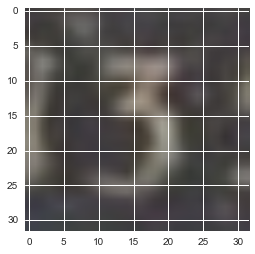

3.0


In [7]:
#rd = random.randint(0, len(train_dataset))
rd = 500
plt.imshow(train_dataset[rd,:,:,:])
plt.show()

print(train_labels[rd])

#### Image Preprocessing

In [13]:
INITIAL_IMAGE_SIZE = 32
INITIAL_NUM_CHANNELS = 3
IMAGE_SIZE = 32
NUM_CHANNELS = 1
NUM_LABELS = 10

def images_processing(images):
  # Color to Grayscale using Tensorflow. Is it necessary or efficient? Nope at this point.
  # Use another library or np.array transformation instead. Anyway it works for now.
  grayscale = tf.image.rgb_to_grayscale(images)
  gcn = tf.map_fn(tf.image.per_image_whitening, grayscale) # Global Contrast Normalization
  return gcn

In [14]:
tf_train_dataset = tf.Variable(train_dataset)
tf_test_dataset = tf.Variable(test_dataset)
tf_valid_dataset = tf.Variable(valid_dataset)

tfp_train_dataset = images_processing(tf_train_dataset)
tfp_test_dataset = images_processing(tf_test_dataset)
tfp_valid_dataset = images_processing(tf_valid_dataset)

init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)
train_dataset, test_dataset, valid_dataset = sess.run([tfp_train_dataset, tfp_test_dataset, tfp_valid_dataset])
  
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)  

Training set (73257, 32, 32, 1) (73257,)
Validation set (8000, 32, 32, 1) (8000,)
Test set (18032, 32, 32, 1) (18032,)


#### CHECK

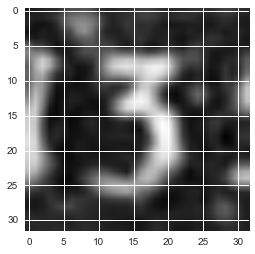

In [15]:
#rd = random.randint(0, len(train_dataset))
rd = 500
sample = train_dataset[rd,:,:,:]
sample = sample.reshape(sample.shape[0], sample.shape[1],).astype(np.float32)
plt.imshow(sample)
plt.show()

#### Randomize

In [16]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels

train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)  

Training set (73257, 32, 32, 1) (73257,)
Validation set (8000, 32, 32, 1) (8000,)
Test set (18032, 32, 32, 1) (18032,)


#### CHECK

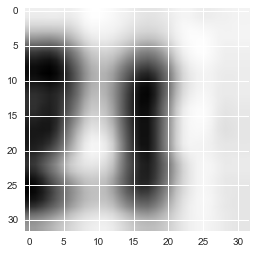

In [17]:
#rd = random.randint(0, len(train_dataset))
rd = 900
sample = train_dataset[rd,:,:,:]
sample = sample.reshape(sample.shape[0], sample.shape[1],).astype(np.float32)
plt.imshow(sample)
plt.show()

#### Save data

In [18]:
# TODO -> DATA TO PICKLE?
pickle_file = '../data/SVHN_data/SVHN-single-digit.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise
    
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 407085315


#### Load data

In [11]:
pickle_file = '../data/SVHN_data/SVHN-single-digit.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (73257, 32, 32, 1) (73257,)
Validation set (8000, 32, 32, 1) (8000,)
Test set (18032, 32, 32, 1) (18032,)


#### CHECK

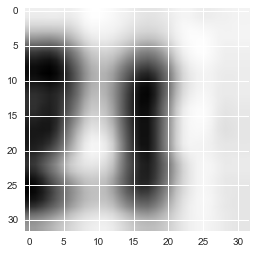

In [12]:
#rd = random.randint(0, len(train_dataset))
rd = 900
sample = train_dataset[rd,:,:,:]
sample = sample.reshape(sample.shape[0], sample.shape[1],).astype(np.float32)
plt.imshow(sample)
plt.show()

### ConvNet 2L - Fully Connected - No Regularization

In [ ]:
IMAGE_SIZE = 32
NUM_CHANNELS = 1
NUM_LABELS = 10

BATCH_SIZE = 64
PATCH_SIZE = 5
DEPTH_1 = 32
DEPTH_2 = 64
NODES = 1024

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(tf.float32, shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS))
  tf_train_labels = tf.placeholder(tf.int64, shape=(BATCH_SIZE))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  # 5x5 Filter, depth 32 
  conv1_weights = tf.Variable(tf.truncated_normal([PATCH_SIZE, PATCH_SIZE, NUM_CHANNELS, DEPTH_1], stddev=0.1))
  conv1_biases = tf.Variable(tf.zeros([DEPTH_1]))
  
  # 5x5 Filter, depth 64
  conv2_weights = tf.Variable(tf.truncated_normal([PATCH_SIZE, PATCH_SIZE, DEPTH_1, DEPTH_2], stddev=0.1))
  conv2_biases = tf.Variable(tf.constant(1.0, shape=[DEPTH_2]))

  # Fully connected depth 256
  fc1_weights = tf.Variable(tf.truncated_normal([IMAGE_SIZE // 4 * IMAGE_SIZE // 4 * DEPTH_2, NODES],
                                                   stddev=0.1))
  fc1_biases = tf.Variable(tf.constant(1.0, shape=[NODES]))
  
  fc2_weights = tf.Variable(tf.truncated_normal([NODES, NUM_LABELS], stddev=0.1))
  fc2_biases = tf.Variable(tf.constant(1.0, shape=[NUM_LABELS]))
  
  # Model.
  def model(data):
    
    kernel1 = tf.nn.conv2d(data, conv1_weights, strides=[1, 1, 1, 1], padding='SAME')
    conv1 = tf.nn.relu(tf.nn.bias_add(kernel1, conv1_biases))
    pool1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    norm1 = tf.nn.local_response_normalization(pool1)

    kernel2 = tf.nn.conv2d(norm1, conv2_weights, [1, 1, 1, 1], padding='SAME')
    conv2 = tf.nn.relu(tf.nn.bias_add(kernel2, conv2_biases))
    norm2 = tf.nn.local_response_normalization(conv2)
    pool = tf.nn.max_pool(norm2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    pool_shape = pool.get_shape().as_list()
    reshape = tf.reshape(pool, [pool_shape[0], pool_shape[1] * pool_shape[2] * pool_shape[3]])
        
    # Fully connected  
    hidden = tf.nn.relu(tf.matmul(reshape, fc1_weights) + fc1_biases)
    return tf.matmul(hidden, fc2_weights) + fc2_biases  
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.sparse_softmax_cross_entropy_with_logits(logits, tf_train_labels))
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.01).minimize(loss) 
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))
  
  
NUM_STEPS = 5001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  for step in range(NUM_STEPS):
    offset = (step * BATCH_SIZE) % (train_labels.shape[0] - BATCH_SIZE)
    batch_data = train_dataset[offset:(offset + BATCH_SIZE), :, :, :]
    batch_labels = train_labels[offset:(offset + BATCH_SIZE)]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

### ConvNet 3L - Fully Connected - No Reg - AdaOptimizer - No Decay: Near 91% 40k steps trained

In [ ]:
IMAGE_SIZE = 32
NUM_CHANNELS = 1
NUM_LABELS = 10

BATCH_SIZE = 64
PATCH_SIZE = 5
DEPTH_1 = 16
DEPTH_2 = 32
DEPTH_3 = 64
NODES = 256

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(tf.float32, shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS))
  tf_train_labels = tf.placeholder(tf.int64, shape=(BATCH_SIZE))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  # 5x5 Filter, depth 16 
  conv1_weights = tf.Variable(tf.truncated_normal([PATCH_SIZE, PATCH_SIZE, NUM_CHANNELS, DEPTH_1], stddev=0.1))
  conv1_biases = tf.Variable(tf.zeros([DEPTH_1]))
  
  # 5x5 Filter, depth 32
  conv2_weights = tf.Variable(tf.truncated_normal([PATCH_SIZE, PATCH_SIZE, DEPTH_1, DEPTH_2], stddev=0.1))
  conv2_biases = tf.Variable(tf.constant(1.0, shape=[DEPTH_2]))
  
  # 5x5 Filter, depth 64
  conv3_weights = tf.Variable(tf.truncated_normal([PATCH_SIZE, PATCH_SIZE, DEPTH_2, DEPTH_3], stddev=0.1))
  conv3_biases = tf.Variable(tf.constant(1.0, shape=[DEPTH_3]))


  # Fully connected 256 Nodes
  fc1_weights = tf.Variable(tf.truncated_normal([IMAGE_SIZE // 4 * IMAGE_SIZE // 4 * DEPTH_3, NODES],
                                                   stddev=0.1))
  fc1_biases = tf.Variable(tf.constant(1.0, shape=[NODES]))
  
  fc2_weights = tf.Variable(tf.truncated_normal([NODES, NUM_LABELS], stddev=0.1))
  fc2_biases = tf.Variable(tf.constant(1.0, shape=[NUM_LABELS]))
  
  # Model.
  def model(data):
    
    kernel1 = tf.nn.conv2d(data, conv1_weights, strides=[1, 1, 1, 1], padding='SAME')
    conv1 = tf.nn.relu(tf.nn.bias_add(kernel1, conv1_biases))
    pool1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    norm1 = tf.nn.local_response_normalization(pool1)
    
    kernel2 = tf.nn.conv2d(norm1, conv2_weights, strides=[1, 1, 1, 1], padding='SAME')
    conv2 = tf.nn.relu(tf.nn.bias_add(kernel2, conv2_biases))
    pool2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    norm2 = tf.nn.local_response_normalization(pool2)

    kernel3 = tf.nn.conv2d(norm2, conv3_weights, [1, 1, 1, 1], padding='SAME')
    conv3 = tf.nn.relu(tf.nn.bias_add(kernel3, conv3_biases))
    norm3 = tf.nn.local_response_normalization(conv3)
    #pool = tf.nn.max_pool(norm3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    pool = norm3
    
    pool_shape = pool.get_shape().as_list()
    reshape = tf.reshape(pool, [pool_shape[0], pool_shape[1] * pool_shape[2] * pool_shape[3]])
        
    # Fully connected  
    hidden = tf.nn.relu(tf.matmul(reshape, fc1_weights) + fc1_biases)
    return tf.matmul(hidden, fc2_weights) + fc2_biases  
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.sparse_softmax_cross_entropy_with_logits(logits, tf_train_labels))
    
  # Optimizer.
  optimizer = tf.train.AdagradOptimizer(0.01).minimize(loss) 
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))
  
  saver = tf.train.Saver()

  
NUM_STEPS = 5001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  sp = saver.restore(session, "../tmp/SVHN-CNN-single-1.ckpt")
  print('Model Restored')
  print('Initialized')
  for step in range(NUM_STEPS):
    offset = (step * BATCH_SIZE) % (train_labels.shape[0] - BATCH_SIZE)
    batch_data = train_dataset[offset:(offset + BATCH_SIZE), :, :, :]
    batch_labels = train_labels[offset:(offset + BATCH_SIZE)]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels))
  sp = saver.save(session, "../tmp/SVHN-CNN-single-1.ckpt")
  print('Model Saved')
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

### Let's make some preds 

In [21]:
test_samples = test_dataset[0:64]
print(test_samples.shape)

(64, 32, 32, 1)


Model Restored
Initialized
Accuracy: 95.3%


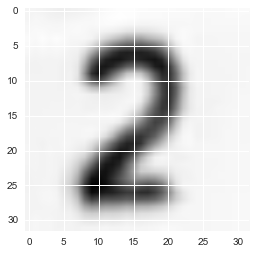

Label 2 - Prediction 2


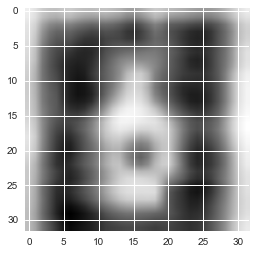

Label 6 - Prediction 6


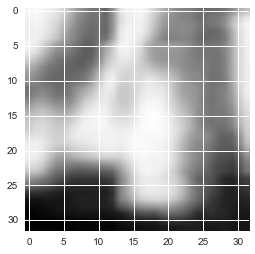

Label 4 - Prediction 4


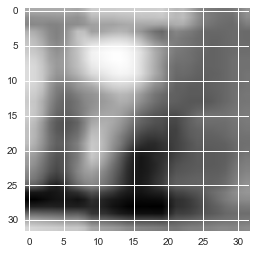

Label 7 - Prediction 7


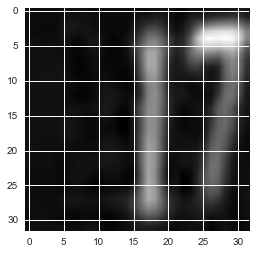

Label 1 - Prediction 1


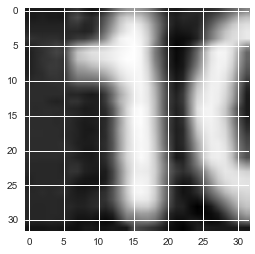

Label 1 - Prediction 1


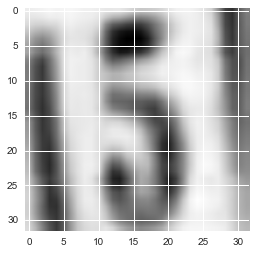

Label 5 - Prediction 5


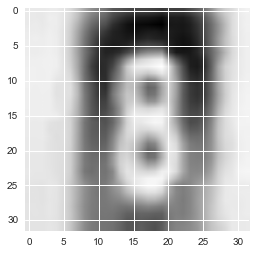

Label 8 - Prediction 8


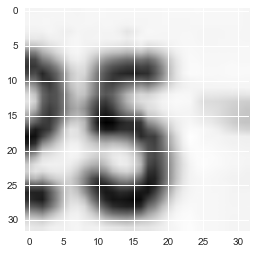

Label 5 - Prediction 5


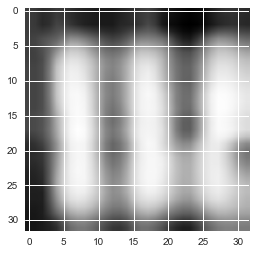

Label 1 - Prediction 1


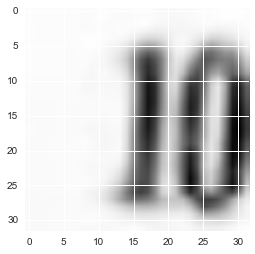

Label 1 - Prediction 1


In [24]:
IMAGE_SIZE = 32
NUM_CHANNELS = 1
NUM_LABELS = 10

SAMPLES = 64

PATCH_SIZE = 5
DEPTH_1 = 16
DEPTH_2 = 32
DEPTH_3 = 64
NODES = 256

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_test_dataset = tf.placeholder(tf.float32, shape=(SAMPLES, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS))
  
  # Variables.
  # 5x5 Filter, depth 16 
  conv1_weights = tf.Variable(tf.truncated_normal([PATCH_SIZE, PATCH_SIZE, NUM_CHANNELS, DEPTH_1], stddev=0.1))
  conv1_biases = tf.Variable(tf.zeros([DEPTH_1]))
  
  # 5x5 Filter, depth 32
  conv2_weights = tf.Variable(tf.truncated_normal([PATCH_SIZE, PATCH_SIZE, DEPTH_1, DEPTH_2], stddev=0.1))
  conv2_biases = tf.Variable(tf.constant(1.0, shape=[DEPTH_2]))
  
  # 5x5 Filter, depth 64
  conv3_weights = tf.Variable(tf.truncated_normal([PATCH_SIZE, PATCH_SIZE, DEPTH_2, DEPTH_3], stddev=0.1))
  conv3_biases = tf.Variable(tf.constant(1.0, shape=[DEPTH_3]))


  # Fully connected 256 Nodes
  fc1_weights = tf.Variable(tf.truncated_normal([IMAGE_SIZE // 4 * IMAGE_SIZE // 4 * DEPTH_3, NODES],
                                                   stddev=0.1))
  fc1_biases = tf.Variable(tf.constant(1.0, shape=[NODES]))
  
  fc2_weights = tf.Variable(tf.truncated_normal([NODES, NUM_LABELS], stddev=0.1))
  fc2_biases = tf.Variable(tf.constant(1.0, shape=[NUM_LABELS]))
  
  # Model.
  def model(data):
    
    kernel1 = tf.nn.conv2d(data, conv1_weights, strides=[1, 1, 1, 1], padding='SAME')
    conv1 = tf.nn.relu(tf.nn.bias_add(kernel1, conv1_biases))
    pool1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    norm1 = tf.nn.local_response_normalization(pool1)
    
    kernel2 = tf.nn.conv2d(norm1, conv2_weights, strides=[1, 1, 1, 1], padding='SAME')
    conv2 = tf.nn.relu(tf.nn.bias_add(kernel2, conv2_biases))
    pool2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    norm2 = tf.nn.local_response_normalization(pool2)

    kernel3 = tf.nn.conv2d(norm2, conv3_weights, [1, 1, 1, 1], padding='SAME')
    conv3 = tf.nn.relu(tf.nn.bias_add(kernel3, conv3_biases))
    norm3 = tf.nn.local_response_normalization(conv3)
    #pool = tf.nn.max_pool(norm3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    pool = norm3
    
    pool_shape = pool.get_shape().as_list()
    reshape = tf.reshape(pool, [pool_shape[0], pool_shape[1] * pool_shape[2] * pool_shape[3]])
        
    # Fully connected  
    hidden = tf.nn.relu(tf.matmul(reshape, fc1_weights) + fc1_biases)
    return tf.matmul(hidden, fc2_weights) + fc2_biases  
  
  # Training computation.
  logits = model(tf_test_dataset)
       
  # Pred  
  predictions = tf.nn.softmax(logits)
  test_predictions = tf.argmax(predictions, 1)
  
  saver = tf.train.Saver()
  
  
with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  sp = saver.restore(session, "../tmp/SVHN-CNN-single-1.ckpt")
  print('Model Restored')
  print('Initialized')
  test_samples = test_dataset[0:SAMPLES]
  test_samples_labels = test_labels[0:SAMPLES]
  test_predictions = session.run(test_predictions, feed_dict={tf_test_dataset : test_samples})
  check_predictions(test_samples, test_samples_labels, test_predictions)
  